<a href="https://colab.research.google.com/github/AhmadZakkiZainalAbidin/Guide_to_Image_Quality/blob/main/n2v_RGB_Images_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nose to Void (N2V) Untuk Denoise Image**

**Instal Direktori yang diperlukan**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install n2v

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 13.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.w

In [ ]:
import tensorflow as tf
import n2v

print(tf.__version__)
print(n2v.__version__)

2.15.0
0.3.3


In [ ]:
#import seluruh library yang diperlukan
from n2v.models import N2VConfig, N2V
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

import numpy as np
import matplotlib.pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**Mempersiapkan File**

catatan gunakan file gambar dengan noise memiliki format .png karena model tidak support dengan format file lain. Gunakan pula dimensi gambar YXC agar dapat terbaca

In [ ]:
datagen = N2V_DataGenerator()

In [ ]:
#Upload File

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Then you can use the uploaded file in your code.
  # For example, you can save it to a file:
  with open(fn, 'wb') as f:
    f.write(uploaded[fn])


Saving images.png to images.png
User uploaded file "images.png" with length 33669 bytes


In [ ]:
#Gambar dibaca dengan memanfaatkan datagen
image =datagen.load_imgs_from_directory(directory ='/content/',
                                        filter='a-low-contrast-image-b-after-enhancement*.png', dims ='YXC') #Gunakan ZYX untuk 3Dimensi

#Informasi gambar
print(f'bentuk gambar yang diload : {image[0].shape}')
#Jika hasil output shape menghasilkan nilai 4 maka selain ada RGB channel juga terdapat alpha channel

image[0]= image[0][...,:3]
print(f'bentuk tanpa alphs{image[0].shape}')
print(f'tipe data dari gambar pertama adalah : {image[0].dtype}')

bentuk gambar yang diload : (1, 256, 256, 4)
bentuk tanpa alphs(1, 256, 256, 3)
tipe data dari gambar pertama adalah : float32


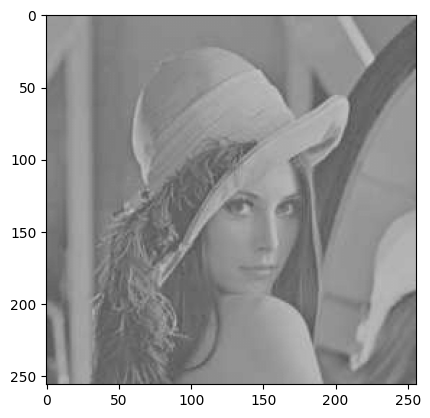

In [ ]:
#Penampilan gambar
plt.figure()
plt.imshow(image[0][0,:,:,:])
plt.show()

In [ ]:
#bagi gambar menjadi pathc (64 atau 32)
patch_size =64

patch_shape = (patch_size, patch_size)
patches = datagen.generate_patches_from_list(image, shape = patch_shape)

Generated patches: (128, 64, 64, 3)


In [ ]:
#Tampilkan shape gambar
patches.shape

(128, 64, 64, 3)

In [ ]:
#paches digunakan agar gambar tidak overlap
#tidak patche yang overlap menyebabkan kita dapat membaginya menjadi traingin dan validation set
train_val_split = int(0.8*patches.shape[0])
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [ ]:
print(f"ukuran train gambar = {X.shape}, Tiper data train = {X.dtype}, ukuran gambar validasi = {X_val.shape}")

ukuran train gambar = (102, 64, 64, 3), Tiper data train = float32, ukuran gambar validasi = (26, 64, 64, 3)


In [ ]:
#Untuk mengakses docstring dari cara yang digunakkan:
datagen.generate_patches_from_list?

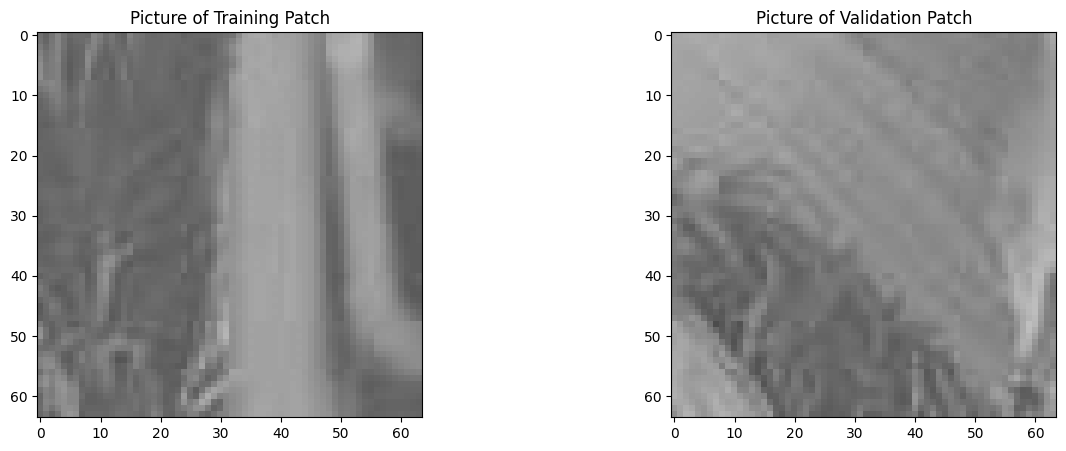

In [ ]:
#Tampilkan gambar yang dibagi menjadi patch training dan patch validasi
input ={"Training Patch" : X[0,...], "Validation Patch": X_val[0,...]}

# membuat subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the histogram untuk tiap channel
for i, (key, value) in enumerate(input.items()):
    axs[i].imshow(value)
    axs[i].set_title(f'Picture of {key}')

# Show the plot
plt.show()

**Configurasi N2V**

Noise2Void memiliki konfigurasi milibatkan kita menyimpan jaringan arsitektur dan training parameter. untuk memperjelas informasi konfigurasi ini anda dapat mengetik.


```
# N2VConfig?
```

Ketika kita membuat objek configurasi, kita melibatkan data train yaitu X, dari X kita akan melakukan ekstraksi rata-rata dan standar deviasi yang akan digunakan untuk melakukan normalisasi seluruh data sebelum dilakukan processing ke dalam jaringan arsitektur. Channel dimensi juga perlu dilakukan pengaturan (dimana dalam notebook ini menggunakan 3 channel)

Direkomendasikan penggunakan model N2V dengan meningkatkan ```train_batch_size``` dan ```batch_norm``` untuk menjaga jaringan mempelajari identitas data saat kita melakukan manipulasi input pixel saat training model. Parameter devaluld yang digunakan itu yaitu ```n2v_manipulator``` dengan nilai default 'uniform_withCP'. sebagian besar manipulator pixel bekerja dengan melakukan komputasi dari pergantian nilai didasarkan pixel tetangga. dengan ```n2v_neighborhood_radius``` kita bisa melakukan kontrol ukuran jangkauan yang pixel tetangga diperlukan

**Penjelasan tambahan terkait pixel manipulator lain**



*   ```normal_withoutCP``` : sample dari pixel tetangga didasarkan pada distribusi normal gaussian namun tanpa menggunakan pixel tengah
*   ```normal_aditive``` : menambahkan sejumlah nilai angka acak kepada nilai pixel. Nilai random ini diambil dari proses sampling distribusi gausian dengan nilai ```zero-mean```  dan ```sigma = n2v_neighborhood_radius```
*   ```normal_fitted``` : menggunakan nilai acak dari distribusi gaussian normal dengan nilai mean sama dengan nilai mean dari pixel tetangga dan nilai standar deviasi yang sama dengan standart deviasi tetangga
*   ```identity``` : tidak penyatakan pixel manipulasi



Untuk menghasilkan proses training yang cepat pada beberapa pixel tiap input, nilai pach dapat diubah-ubah. Pada note book ini kita akan menggunakan nilai pengaturan dengan 0.198% dari nilai input pixels per patch. Nilai ukuran patch dimiliki sebesar 64 dari 64 pixel yang berkorespondensi dengan 8 pixel. Nilai fraksi ini dapat diatur pada ```n2v_perc_pix```.


Pada proses training Noise2Void sangat dimungkinkan untuk melewati patch yang besar secara langsung pada cara training. Melalui patcch ini beberapa subpatche acak dengan ukuran ```n2v_patche_shape``` akan diekstraksi saat training. nilai defauld dari patch shape adalah (64,64)


Selanjutnya untuk mengatasu bleedthrough artifact kita dapat menambahkan opsi `single_net_per_channel` , yang akan menyala secara defauld. Dengan menggunakan single U-Net channel yang akan secara independen dibuat dan ditrain yang akan menghilangkan kemungkinan bleedthrough.


Catatan : Secara esensial jaringan akan mengalami ppenggandaan oleh banyaknya channel. yang akan meningkatkan jumlah memori yang diperlukan. Jika kita menggunakan GPU yang kecil maka proses ini perlu kita lakukan split channel secara manual dan melakukan proses train jaringan untuk  setiap channel secara berurutan.


Oleh karenanya, pada notebook contoh ini, untuk mengeksekusi secara cepat kita dapat mengatur `train_epochs` menjadi 10. untuk nilai yang lebih baik bisa gunakan 100 hingga 200 `train_epochs`



In [ ]:
#Lakukan konfigurasi model
train_batch =32
config = N2VConfig(X, unte_kern_size=3,
                   unet_n_first=64,
                   unet_n_depth=3,
                   train_steps_per_epoch= int(X.shape[0]/train_batch),
                   train_epochs=20,
                   train_loss='mse',
                   batch_norm=True,
                   train_batch_size=train_batch,
                   n2v_per_pix=0.198,
                   n2v_patch_shape=(patch_size, patch_size),
                   n2v_manpulator='unifrom_withCP',
                   n2v_neighborhood_darius=5,
                   single_net_perchannel=False)

#Tampilkan parameter yang telah dikonfigurasi
vars(config)

{'means': ['0.54052275', '0.54052275', '0.54052275'],
 'stds': ['0.089778565', '0.089778565', '0.089778565'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 5,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 3,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False,
 'unte_kern_size': 3,
 'n2v_per_pix': 0.198,
 'n2v_manpulator': 'unifrom_withCP',
 'n2v_neighborhood_darius': 5,
 'single_net_perchannel': Fa

In [ ]:
model_name ='n2v_2D_likely'
basedir = 'models'
model=N2V(config, model_name, basedir=basedir)

**Melakukan Model Training**

In [ ]:
history = model.train(X, X_val)

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 26/26 [00:00<00:00, 44.20it/s]


Epoch 1/20
3/3 [==============================] - 265s 80s/step - loss: 1.3073 - n2v_mse: 1.3073 - n2v_abs: 0.8546 - val_loss: 0.8064 - val_n2v_mse: 0.8064 - val_n2v_abs: 0.7442 - lr: 4.0000e-04
Epoch 2/20
3/3 [==============================] - 232s 85s/step - loss: 0.4094 - n2v_mse: 0.4094 - n2v_abs: 0.4691 - val_loss: 0.7564 - val_n2v_mse: 0.7564 - val_n2v_abs: 0.7162 - lr: 4.0000e-04
Epoch 3/20
3/3 [==============================] - 244s 88s/step - loss: 0.1922 - n2v_mse: 0.1922 - n2v_abs: 0.3256 - val_loss: 0.8052 - val_n2v_mse: 0.8052 - val_n2v_abs: 0.7213 - lr: 4.0000e-04
Epoch 4/20
3/3 [==============================] - 209s 74s/step - loss: 0.1149 - n2v_mse: 0.1149 - n2v_abs: 0.2396 - val_loss: 1.2680 - val_n2v_mse: 1.2680 - val_n2v_abs: 0.8230 - lr: 4.0000e-04
Epoch 5/20
3/3 [==============================] - 207s 73s/step - loss: 0.0951 - n2v_mse: 0.0951 - n2v_abs: 0.2250 - val_loss: 1.6308 - val_n2v_mse: 1.6308 - val_n2v_abs: 0.8586 - lr: 4.0000e-04
Epoch 6/20
3/3 [=========

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


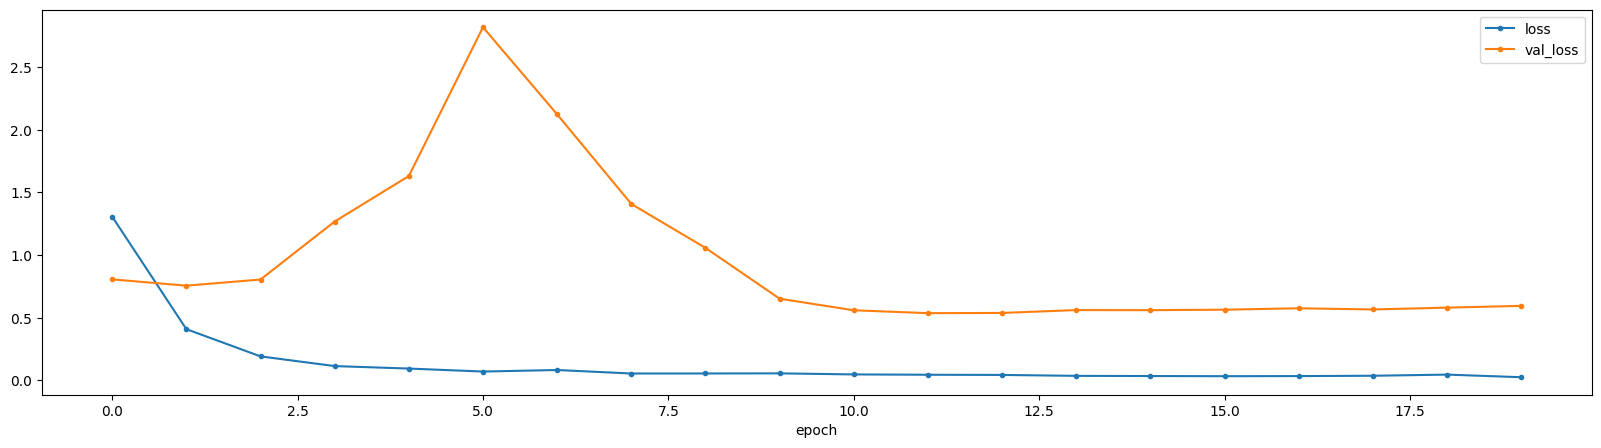

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(20,5))
plot_history(history, ['loss', 'val_loss'])

**Melakukan Proses Denoishing dengan Model Train**

In [ ]:
from n2v.models import N2V
from csbdeep.io import save_tiff_imagej_compatible

import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import numpy as np

In [ ]:
#Buat object N2V tanpa menambahkan config
model_name = 'n2v_2D_likely'
basedir = 'models'
model = N2V(config =None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [ ]:
#Load gambar yang akan kita proses (Gambar sama dengan pelatihan)
img = imread('/content/a-low-contrast-image-b-after-enhancement.png')
img.dtype

dtype('float32')

In [ ]:
img.shape

(256, 256, 4)

In [ ]:
img= img[...,:3]

In [ ]:
#Melakukan proses denoise menggunakan model.predict
#parameter yang bisa digunakan yaitu 'n_tiles' jika gambar terlalu besar untuk GPU
#jika tidak menggunakan 'n_tiles' maka parameter sistem akan secara otomatis mencari tiling yang sesuai
#Dimana akan memakan banyak waktu

pred = model.predict(img, axes='YXC')

1/1 [==============================] - 10s 10s/step


In [ ]:
pred.shape

(256, 256, 3)

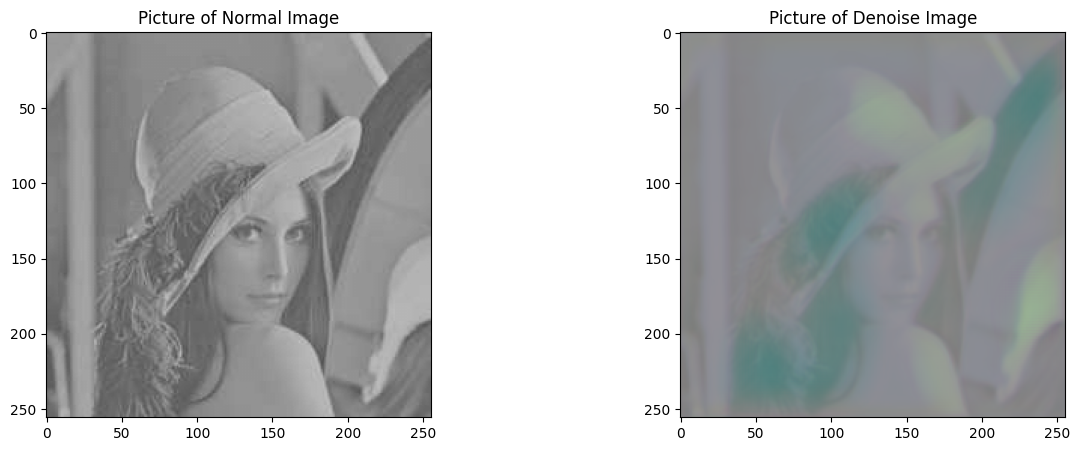

In [ ]:
input ={"Normal Image" : img, "Denoise Image": pred}
# membuat subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the histogram untuk tiap channel
for i, (key, value) in enumerate(input.items()):
    axs[i].imshow(value)
    axs[i].set_title(f'Picture of {key}')

# Show the plot
plt.show()

**Menyimpan Gambar Hasil Denoise**

In [ ]:
#Gunakan antara 2 kode dibawah
#imsave('namagambar.format', pred)
#save_tiff_imagej_compatible('namagambar.tif', pred, axes='YXC')

# **Penggunaan Denoise Untuk Data set Lain + Simplified code**

## **Direktori yang diperlukan**

In [18]:
!pip install tensorflow

In [19]:
!pip install n2v

## **Proses Denoise**

**Import Library**

In [20]:
import tensorflow as tf
import n2v

print(tf.__version__)
print(n2v.__version__)

2.15.0
0.3.3


In [21]:
#import seluruh library yang diperlukan
from n2v.models import N2VConfig, N2V
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

import numpy as np
import matplotlib.pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**Upload Dan Persiapkan Gambar**

In [33]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Then you can use the uploaded file in your code.
  # For example, you can save it to a file:
  with open(fn, 'wb') as f:
    f.write(uploaded[fn])

Saving images1.png to images1 (1).png
User uploaded file "images1 (1).png" with length 118268 bytes


In [22]:
datagen = N2V_DataGenerator()

In [34]:
#Import Gambar dengan datagenerator N2V
image =datagen.load_imgs_from_directory(directory ='/content/',
                                        filter='images1 (1)*.png', dims ='YXC') #Gunakan ZYX untuk 3Dimensi

#Informasi gambar
print(f'bentuk gambar yang diload : {image[0].shape}')
#Jika hasil output shape menghasilkan nilai 4 maka selain ada RGB channel juga terdapat alpha channel

image[0]= image[0][...,:3]
print(f'bentuk tanpa alphs{image[0].shape}')
print(f'tipe data dari gambar pertama adalah : {image[0].dtype}')

bentuk gambar yang diload : (1, 266, 400, 4)
bentuk tanpa alphs(1, 266, 400, 3)
tipe data dari gambar pertama adalah : float32


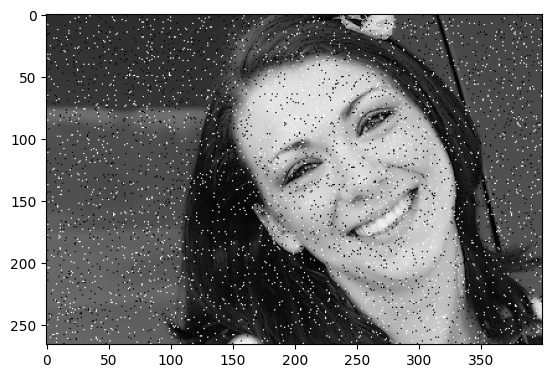

Generated patches: (192, 64, 64, 3)
ukuran train gambar = (153, 64, 64, 3), Tiper data train = float32, ukuran gambar validasi = (39, 64, 64, 3)


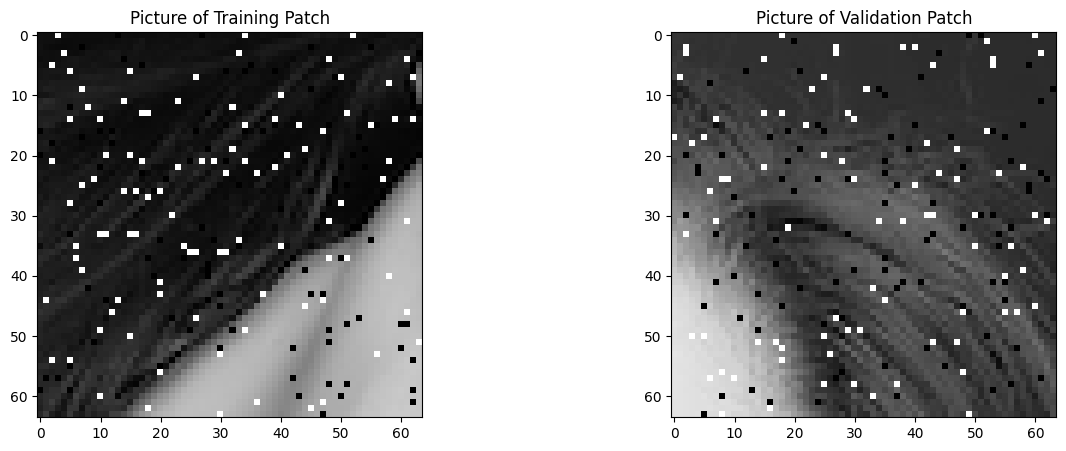

In [35]:
plt.figure()
plt.imshow(image[0][0,:,:,:])
plt.show()
#bagi gambar menjadi pathc (64 atau 32)
patch_size =64

patch_shape = (patch_size, patch_size)
patches = datagen.generate_patches_from_list(image, shape = patch_shape)
patches.shape

#paches digunakan agar gambar tidak overlap
#tidak patche yang overlap menyebabkan kita dapat membaginya menjadi traingin dan validation set
train_val_split = int(0.8*patches.shape[0])
X = patches[:train_val_split]
X_val = patches[train_val_split:]
print(f"ukuran train gambar = {X.shape}, Tiper data train = {X.dtype}, ukuran gambar validasi = {X_val.shape}")
#Tampilkan gambar yang dibagi menjadi patch training dan patch validasi
input ={"Training Patch" : X[0,...], "Validation Patch": X_val[0,...]}

# membuat subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the histogram untuk tiap channel
for i, (key, value) in enumerate(input.items()):
    axs[i].imshow(value)
    axs[i].set_title(f'Picture of {key}')

# Show the plot
plt.show()

In [36]:
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.3805492', '0.3805492', '0.3805492'],
 'stds': ['0.27392843', '0.27392843', '0.27392843'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 4,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [37]:
model_name ='n2v_2D_likely'
basedir = 'models'
model=N2V(config, model_name, basedir=basedir)

**Model Train**

In [38]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 39/39 [00:00<00:00, 319.01it/s]


Epoch 1/20
4/4 [==============================] - 40s 8s/step - loss: 1.4354 - n2v_mse: 1.4354 - n2v_abs: 0.9146 - val_loss: 0.8161 - val_n2v_mse: 0.8620 - val_n2v_abs: 0.7740 - lr: 4.0000e-04
Epoch 2/20
4/4 [==============================] - 32s 8s/step - loss: 0.8093 - n2v_mse: 0.8093 - n2v_abs: 0.7013 - val_loss: 0.7177 - val_n2v_mse: 0.7550 - val_n2v_abs: 0.7272 - lr: 4.0000e-04
Epoch 3/20
4/4 [==============================] - 30s 8s/step - loss: 0.6104 - n2v_mse: 0.6104 - n2v_abs: 0.6147 - val_loss: 0.6636 - val_n2v_mse: 0.7010 - val_n2v_abs: 0.6934 - lr: 4.0000e-04
Epoch 4/20
4/4 [==============================] - 32s 8s/step - loss: 0.4093 - n2v_mse: 0.4093 - n2v_abs: 0.5050 - val_loss: 0.6274 - val_n2v_mse: 0.6675 - val_n2v_abs: 0.6682 - lr: 4.0000e-04
Epoch 5/20
4/4 [==============================] - 34s 9s/step - loss: 0.2885 - n2v_mse: 0.2885 - n2v_abs: 0.4186 - val_loss: 0.5807 - val_n2v_mse: 0.6193 - val_n2v_abs: 0.6366 - lr: 4.0000e-04
Epoch 6/20
4/4 [===================

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


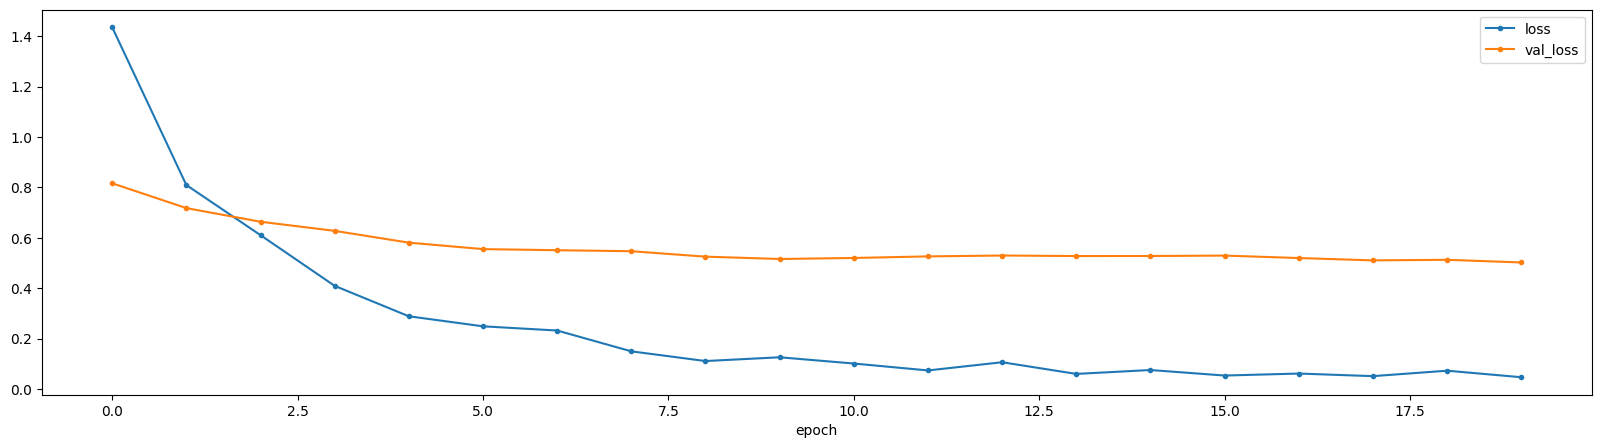

In [39]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(20,5))
plot_history(history, ['loss', 'val_loss'])

**Melakuka Proses Denoising**

In [40]:
from n2v.models import N2V
import matplotlib.pyplot as plt
from matplotlib.image import imread, imsave
import numpy as np

In [41]:
#Buat object N2V tanpa menambahkan config
model_name = 'n2v_2D_likely'
basedir = 'models'
model = N2V(config =None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [44]:
#Karena gambar terdapat A channel maka jadikan hanya RGB channel
img = imread('/content/images1 (1).png')
print(f'Tipe Data {img.dtype}, shape {img.shape}')

Tipe Data float32, shape (266, 400, 4)


In [46]:
#Menghilangkan A channel
img= img[...,:3]
print(f'Tipe Data {img.dtype}, shape {img.shape}')

Tipe Data float32, shape (266, 400, 3)


In [47]:
#Melakukan Denosing Dengan Prediksi
pred = model.predict(img, axes='YXC')
print(f'Tipe Data {pred.dtype}, shape {pred.shape}')

1/1 [==============================] - 2s 2s/step
Tipe Data float32, shape (266, 400, 3)


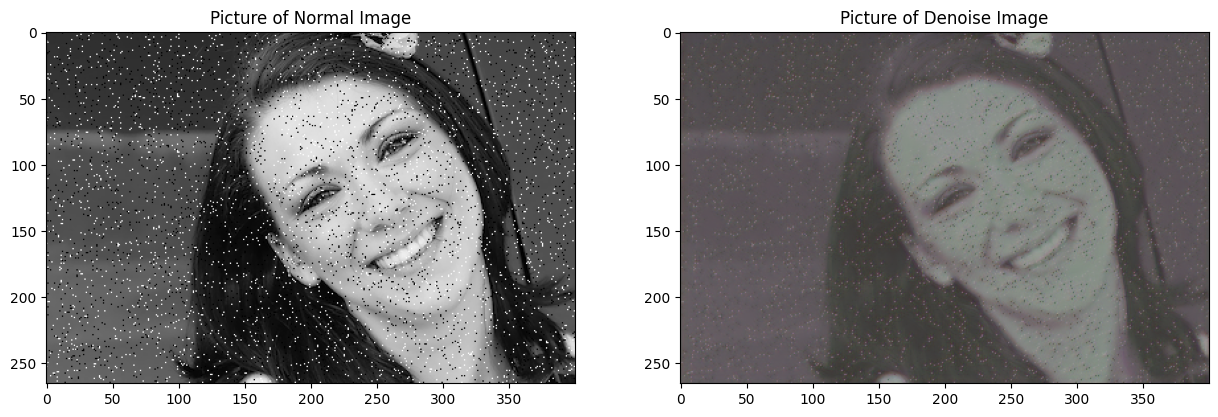

In [48]:
#Tampilkan Hasil Gambar Normal vs hasil Denoising
input ={"Normal Image" : img, "Denoise Image": pred}
# membuat subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the histogram untuk tiap channel
for i, (key, value) in enumerate(input.items()):
    axs[i].imshow(value)
    axs[i].set_title(f'Picture of {key}')

# Show the plot
plt.show()

**Melakukan Save Hasil Gambar**

In [49]:
imsave('/content/denoise image.png',pred)